In [107]:
import numpy as np # linear algebra

import seaborn as sns
col_pal = sns.palettes.hls_palette()
sns.set_palette(col_pal)
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

PW = 10
PH = 6
plt.rcParams['figure.figsize'] = (PW, PH) 
#plt.rcParams['image.cmap'] = 'grey'

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

import datetime as dt
from scipy.stats import ttest_ind, pearsonr, spearmanr

dir_path = "./Meteorological Data/" 
%matplotlib inline

import os
print(os.listdir(dir_path))

['Melbourne - 086071-Table 1.csv', 'Brisbane - 040913-Table 1.csv', 'Adelaide - 023090-Table 1.csv', 'Perth - 009225-Table 1.csv', 'Sydney - 066062-Table 1.csv']


In [108]:
files = ['Melbourne - 086071-Table 1.csv', 'Brisbane - 040913-Table 1.csv',
         'Adelaide - 023090-Table 1.csv', 'Perth - 009225-Table 1.csv', 'Sydney - 066062-Table 1.csv']

## Preprocessing

In [109]:
#Dict for renamimng columns
name_map= { u'Minimum temperature (°C)':"MinTemp",
                u'Maximum temperature (°C)': "MaxTemp",
                           u'Rainfall (mm)': "Rainfall",
                        u'Evaporation (mm)': "Evaporation",
                        u'Sunshine (hours)': "Sunshine",
         u'Direction of maximum wind gust ': "DirectOfMaxWind", 
       u'Speed of maximum wind gust (km/h)': "SpeedOfMaxWind",
               u'Time of maximum wind gust': "TimeOfMaxWind",
                    u'9am Temperature (°C)': "9am_Temp",
               u'9am relative humidity (%)': "9am_RelHumid",
                u'9am cloud amount (oktas)': "9am_Clouds",
                      u'9am wind direction': "9am_WindDirect",
                   u'9am wind speed (km/h)': "9am_WindSpeed",
                  u'9am MSL pressure (hPa)': "9am_Preassure",
                    u'3pm Temperature (°C)': "3pm_Temp",
               u'3pm relative humidity (%)': "3pm_RelHumid",
                u'3pm cloud amount (oktas)': "3pm_Clouds",
                      u'3pm wind direction': "3pm_WindDirect",
                   u'3pm wind speed (km/h)': "3pm_WindSpeed",
                  u'3pm MSL pressure (hPa)': "3am_Preassure",
                                 u'Quarter': u'Quarter',
                                  "TempVar":"TempVar",
                            "9am_Clouds_Av":"9am_Clouds_Av",
                            "3pm_Clouds_Av":"3pm_Clouds_Av",
                    "Average Rel. Humidity":"Average Rel. Humidity"}

rev_name_map = {v: k for k, v in name_map.iteritems()}

In [110]:
city = 0
days = 365
df = pd.read_csv(dir_path + files[city], encoding="utf-8")
df["City"] = files[city].split(" ")[0]
df = df[-days:]

for city in range(1, len(files)):
    
    tdf = pd.read_csv(dir_path + files[city], encoding="utf-8")
    tdf = tdf[-days:]
    
    #Drop Unnamed Column
    if city in [1,2,4]:
        tdf.drop([tdf.columns[-1]], axis=1, inplace=True)
    
    tdf["City"] = files[city].split(" ")[0]
    df = pd.concat([df, tdf])
        
#Save Date for plotting
df["DateI"] = pd.to_datetime(df.Date)

df.set_index(pd.to_datetime(df.Date), inplace=True)

#Sort df
df = df.sort_values(["DateI","City"])

#Rename Columns
df.rename(index=str, columns=name_map, inplace=True)

#Add quartals of the year
df["Quarter"] = df.DateI.apply(lambda x: pd.Timestamp(x).quarter)
#Infere Season
df["Season"] = df["Quarter"].apply(lambda x: "Q2Q3" if x in[2,3] else "Q4Q1")

#New Columns
df["TempVar"] = df[u"MaxTemp"] - df[u"MinTemp"]

#Drop columns
df.drop(["Day","Date"], axis=1, inplace=True)

df.head(3)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,DirectOfMaxWind,SpeedOfMaxWind,TimeOfMaxWind,9am_Temp,9am_RelHumid,9am_Clouds,9am_WindDirect,9am_WindSpeed,9am_Preassure,3pm_Temp,3pm_RelHumid,3pm_Clouds,3pm_WindDirect,3pm_WindSpeed,3am_Preassure,City,DateI,Quarter,Season,TempVar
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,22.0,33.0,NaN,NaN,0.5,WSW,43.0,13:15,29.8,29.0,NaN,ENE,4.0,1006.1,29.7,50.0,NaN,SSW,24.0,1007.0,Adelaide,2014-01-01,1,Q4Q1,11.0
2014-01-01 00:00:00,20.6,30.6,0.0,3.4,12.5,ENE,31.0,14:18,28.8,52.0,4.0,SE,7.0,1015.2,28.9,52.0,1.0,ENE,11.0,1013.1,Brisbane,2014-01-01,1,Q4Q1,10.0
2014-01-01 00:00:00,16.2,26.3,0.0,10.6,0.0,N,80.0,11:01,21.9,91.0,NaN,N,43.0,1010.1,NaN,NaN,NaN,N,35.0,1003.7,Melbourne,2014-01-01,1,Q4Q1,10.1


##  Fill NaNs

In [111]:
#IsNan Cols#IsNan C 
p = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
p = p[p > 0]
p

3pm_Clouds         0.295342
9am_Clouds         0.276712
Evaporation        0.065753
Rainfall           0.050411
9am_WindSpeed      0.032877
Sunshine           0.006027
DirectOfMaxWind    0.006027
SpeedOfMaxWind     0.006027
TimeOfMaxWind      0.004384
3pm_WindSpeed      0.003288
3pm_RelHumid       0.002192
3pm_Temp           0.001644
9am_Temp           0.001096
9am_RelHumid       0.001096
TempVar            0.001096
9am_Preassure      0.000548
MaxTemp            0.000548
MinTemp            0.000548
dtype: float64

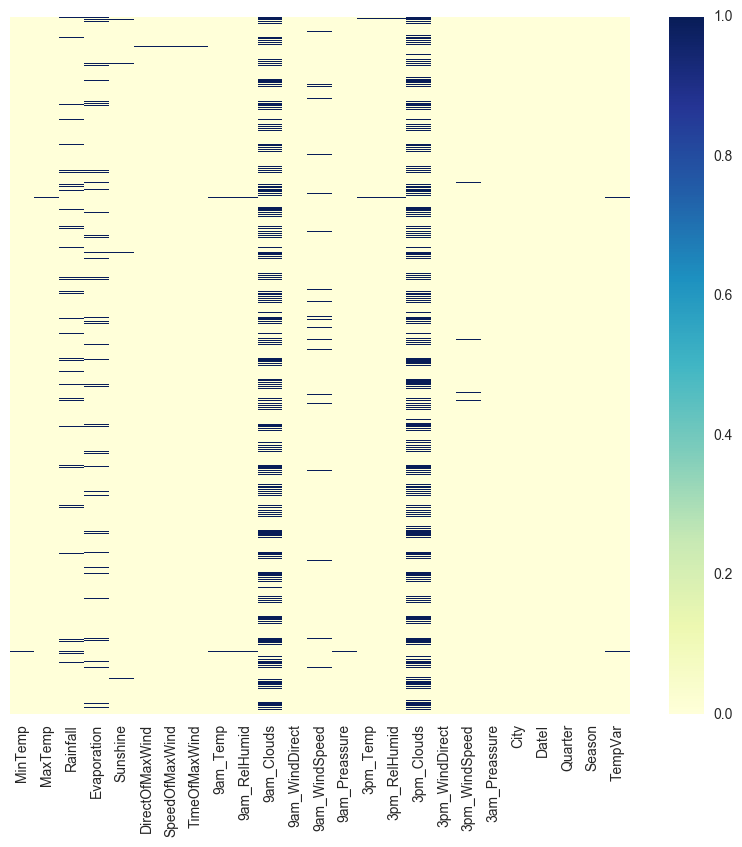

In [112]:
#Plot Nans
f, ax = plt.subplots(1,1,figsize=(PW,1.5*PH))

mnn = pd.DataFrame(np.array(df.isnull().values, dtype='bool')+1-1, columns=df.columns)
sns.heatmap(mnn, ax=ax, yticklabels=False, cmap="YlGnBu");

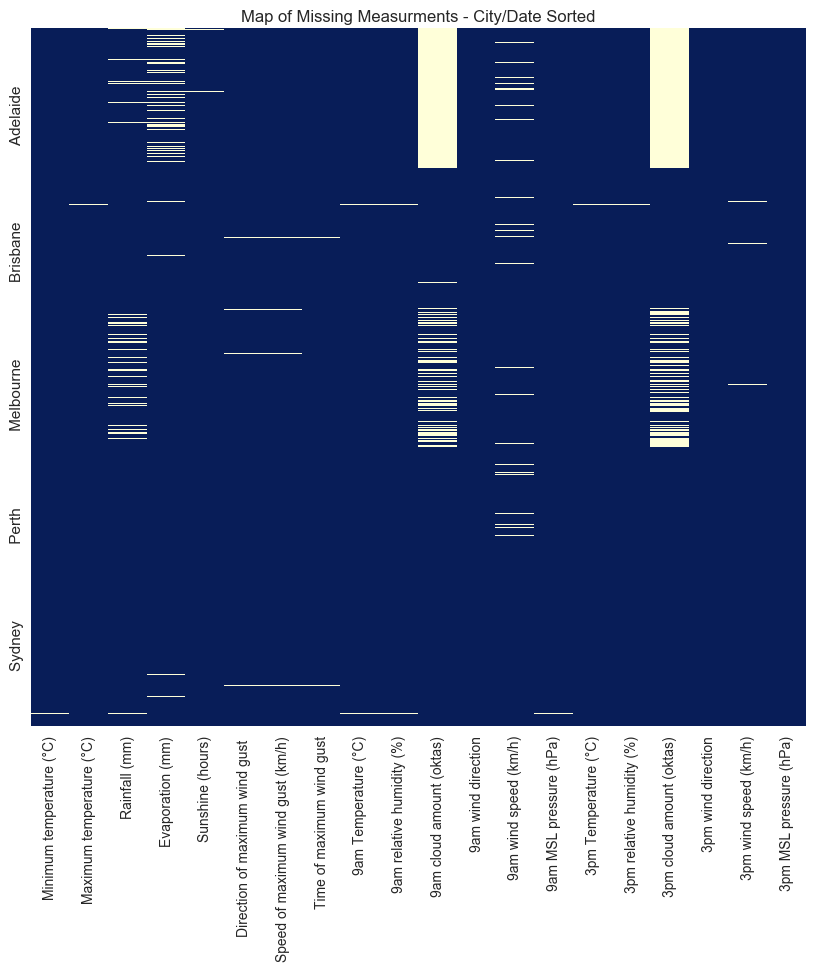

In [113]:
#Plot Nans Per City
f, ax = plt.subplots(1,1,figsize=(PW,1.5*PH))
cols = df.columns[0: len(df.columns) - 5]
topl = df.sort_values(["City","DateI"])[cols]

mnn = pd.DataFrame(np.array(topl.isnull().values, dtype='bool')+1-1, columns=topl.columns)
#Long Names
mnn = mnn.rename(index=str, columns=rev_name_map)
sns_plt = sns.heatmap(mnn, ax=ax, yticklabels=False, cmap="YlGnBu_r", cbar=False);

ax.set_ylabel("                  ".join(['Adelaide', 'Brisbane', 'Melbourne', 'Perth', 'Sydney'][::-1]));
#sns_plt.set_xticklabels(mnn.columns,rotation=30)

plt.title('Map of Missing Measurments - City/Date Sorted');
#sns_plt.figure.savefig("./Plots/" + "NaNs.png")

In [114]:
#Fill zeros for Adeleide
df.loc[df.City =="Adelaide", '9am_Clouds'] = 0
df.loc[df.City =="Adelaide", '3pm_Clouds'] = 0

#Fill Group Median/Mode
medCols = p.index
for col in medCols:
    if df[col].dtype != object:
        df[col] = df[col].fillna(df[col].median())
        df[col] = df.groupby(["City","Quarter"])[col].transform(lambda x: x.fillna(x.median()))
    else:
        df[col] = df.groupby(["City","Quarter"])[col].transform(lambda x: x.fillna(lambda y: y.mode()[0]))

## Exploratory Analysis

In [204]:
#Functions
def rename_for_plt(df, col):
    col = rev_name_map[col]
    topl = df.rename(index=str, columns=rev_name_map)
    return col, topl

def stat_order(topl, order, col):
    topl["Sort"] = topl["City"].map(lambda x: order.loc[col,][x])
    topl = topl.sort_values("Sort", ascending=True)
    return topl
    
def plot_dists(df, p, order=None, plt_type="violin"):  
    
    for col in p:
        if df[col].dtype == object or df[col].dtype == "datetime64[ns]":
            continue
        else:
            topl = df
            if len(topl) > 0:
                f, ax = plt.subplots(1, 1, figsize=(PW,PH))
                
                if order is not None:
                    topl = stat_order(df, order, col)
                
                old_col = col
                col, topl = rename_for_plt(topl, col)
               
                
                plt.title(col + " - Increasing Mean Ordered")
                pal = sns.diverging_palette(200, 20, s=75, l=75, n=2)
                if plt_type == "violin":     
                    sns_plt = sns.violinplot(split=True,x="City", y=col, hue="Season", data=topl, palette=pal, ax=ax)
                elif plt_type == "violin_ns":
                    cities = topl.groupby("City").sum().index
                    idx = [int(order.loc[old_col,][x]) for x in cities]
                    pal = np.array(col_pal)[idx]
                    sns.set_palette(pal)
            
                    sns_plt = sns.swarmplot(x="City", y=col, hue="City", data=topl, ax=ax)
                    sns.set_palette(col_pal)
                elif plt_type == "boxplot":
                    sns_plt = sns.boxplot(x="City", y=col, hue="Season", data=topl, palette=pal, ax=ax)

                plt.legend(bbox_to_anchor=(1, 1), loc=2)
                
def roll(df, col, roll=10):
    ncol = col + "_MA"
    df[ncol] = df.groupby("City")[col].transform(lambda x: x.rolling(roll, min_periods=1).mean())
    df[ncol] = df[ncol].fillna(0)
    return ncol

def cumsumCat(df, col):
    ncol = col + "_CS"
    df[ncol] =  df.groupby(["City"])[col].transform(lambda x: x.cumsum())
    return ncol

def plot_time(topl, col, rev_name_map):
    f, ax = plt.subplots(1,1,figsize=(PW,PH)) 
    topl["Unit"] = 0
    #Rename
    topl = topl.rename(index=str, columns=rev_name_map)
    
    sns_plt = sns.tsplot(data=topl, time="DateI",condition="City", unit="Unit", value=col, ax=ax);

    xticks = ax.get_xticks();
    # convert all xtick labels to selected format from ms timestamp
    ax.set_xticklabels([pd.to_datetime(tm).date() for tm in xticks], rotation=50)

    xticks = ax.get_xticks();
    # convert all xtick labels to selected format from ms timestamp
    ax.set_xticklabels([pd.to_datetime(tm).date() for tm in xticks], rotation=50)

    ax.set_xlabel("Date")
    plt.legend(bbox_to_anchor=(1, 1), loc=2)
    return sns_plt


def rank_stat(df, col):
    cities = df.groupby("City").sum().index.values
    rank = dict(zip(cities,np.zeros(len(cities))))
    for j in range(0,len(cities)):
        c1 = df[df.City==cities[j]]
        for i in range(j+1,len(cities)):
            c2 = df[df.City==cities[i]]
            rank[cities[j]] += ttest_ind(c1[col],c2[col], equal_var=False)[0] > 0 #Welch's
            rank[cities[i]] += ttest_ind(c1[col],c2[col], equal_var=False)[0] <= 0
    return rank

def calc_stat(df, cols):
    stats = []
    for col in cols:
        if df[col].dtype == object or df[col].dtype == "datetime64[ns]":
                continue
        rank = rank_stat(df, col)
        rank["Type"] = col
        stats.append(rank)
    stdf = pd.DataFrame(stats).set_index("Type")

    return stdf

def plot_corr(df, cols):
    #Calculate correlations
    topl = df[cols].rename(index=str, columns=rev_name_map)

    corr = topl.corr()
 
    # Heatmap
    f, ax = plt.subplots(1,1,figsize=(PW,PH)) 
    sns_plt = sns.heatmap(corr, vmin=0, square=True, cmap="YlGnBu", ax=ax, annot=True);
   
    sns_plt.set_xticklabels(topl.columns,rotation=30)
    sns_plt.set_yticklabels(topl.columns,rotation=30);
    plt.title("Perason Correlation's of Temp. Measurements")
    
df.sort_values(["City","DateI"]);

## Sunshine

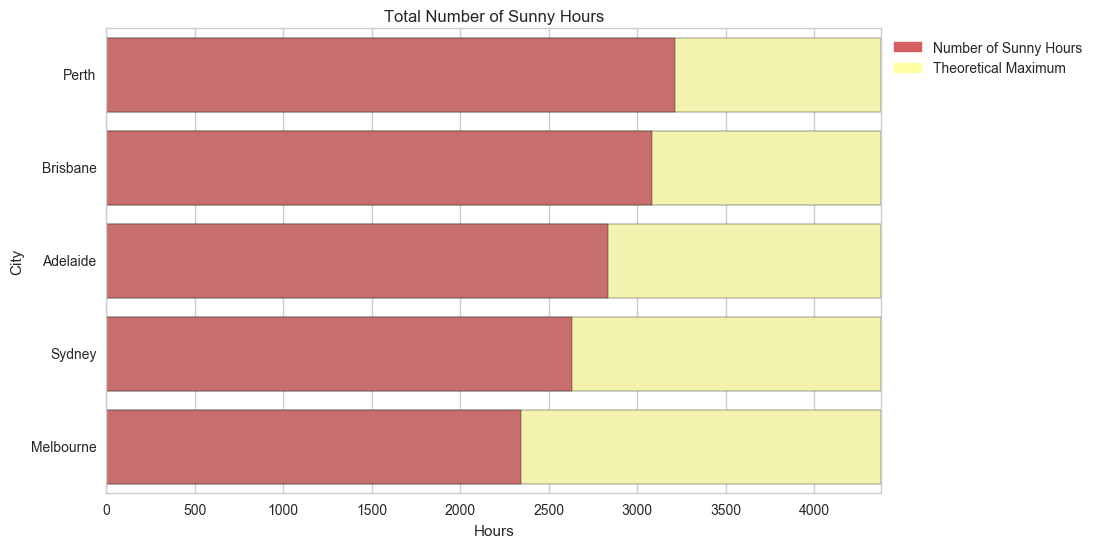

In [116]:
##Sunshine Hours
topl = df.groupby("City",as_index=False).sum()[["Sunshine","City"]] 
#topl["HasRain"] /= days
topl["Total"]  = 12 * days
topl = topl.sort_values("Sunshine", ascending=False)

f, ax = plt.subplots(1,1,figsize=(PW,PH)) 

sns.set_color_codes("pastel")
sns_plt = sns.barplot(x="Total", y="City", data=topl, label="Total", color="y")

sns.set_color_codes("muted")
sns_plt = sns.barplot(x="Sunshine", y="City", data=topl, label="Total", color="r");

sns_plt.set_xlabel("Hours")
sns_plt.set_xlim(0,12 * days)
plt.title('Total Number of Sunny Hours');


red_patch = mpatches.Patch(color='r', label='Number of Sunny Hours')
sns.set_color_codes("pastel")
yellow_patch = mpatches.Patch(color='y', label='Theoretical Maximum') 

plt.legend(handles=[red_patch, yellow_patch], bbox_to_anchor=(1, 1), loc=2);
#plt.legend();

In [117]:
#Scoring
cols = ["Sunshine"]
order = calc_stat(df, cols)
order

,Adelaide,Brisbane,Melbourne,Perth,Sydney
Type,,,,,
Sunshine,2.0,3.0,0.0,4.0,1.0


## Temperature

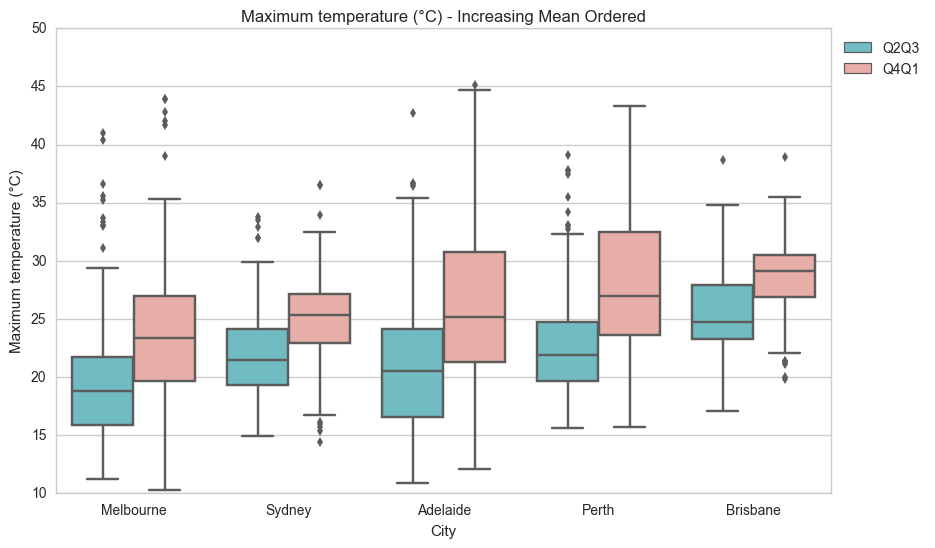

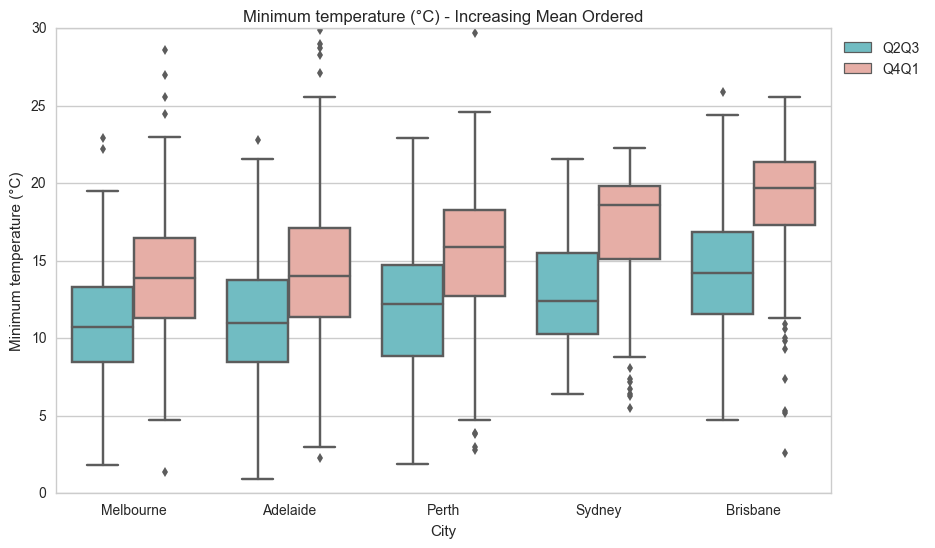

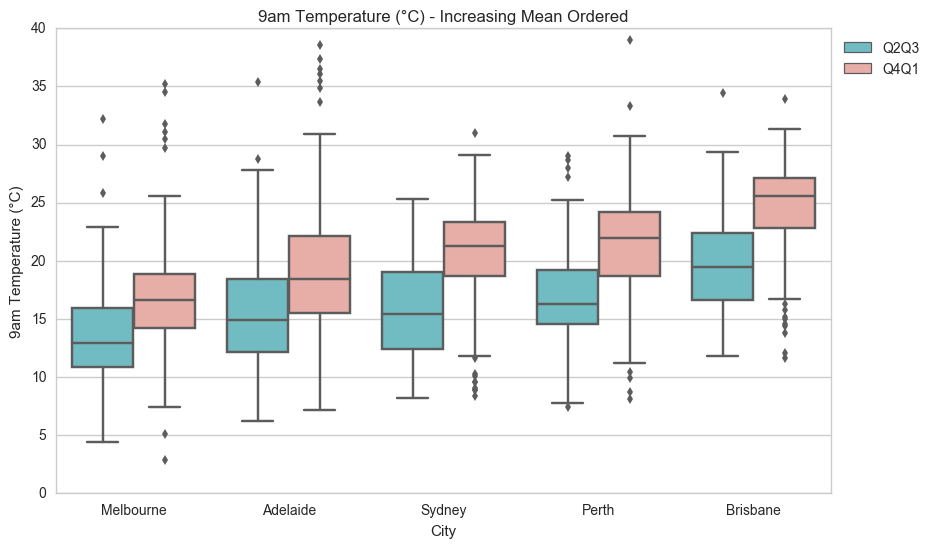

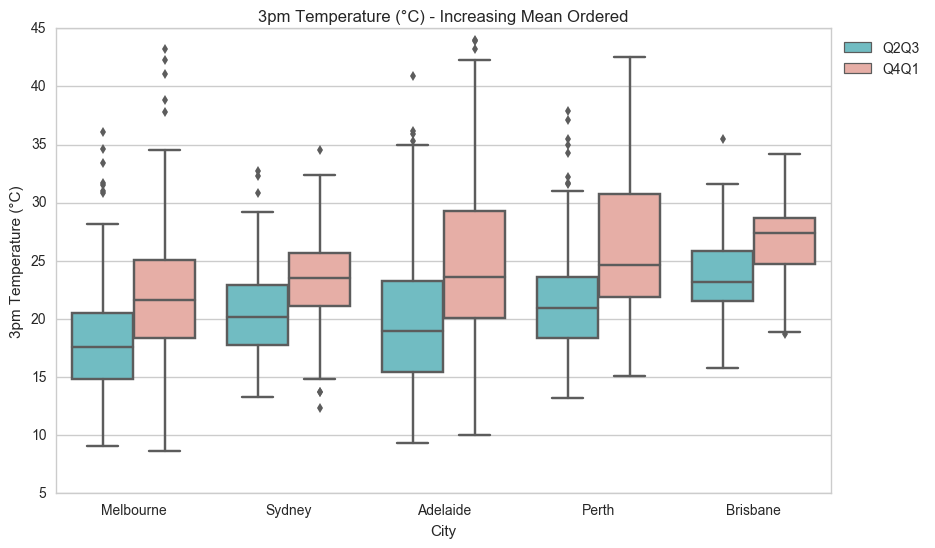

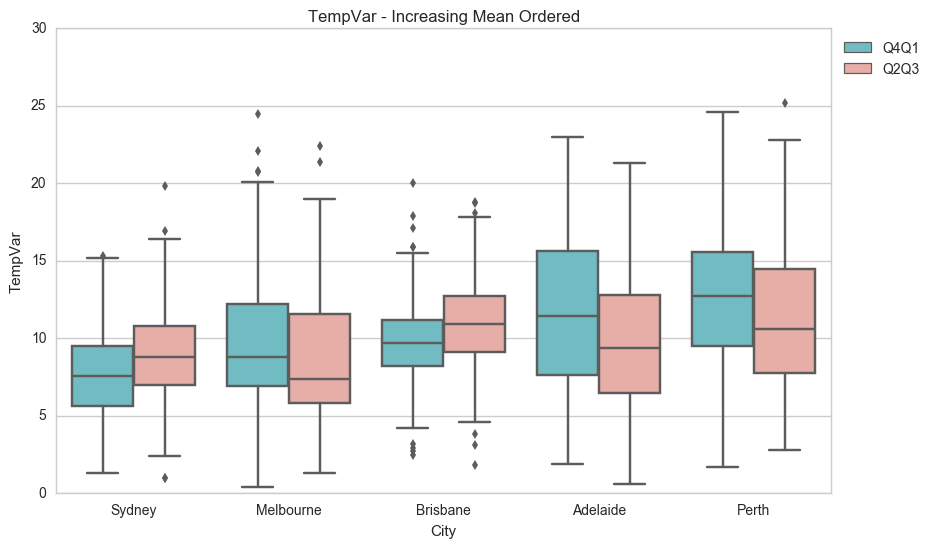

In [143]:
cols = ["MaxTemp","MinTemp","9am_Temp","3pm_Temp","TempVar"]
order = calc_stat(df, cols)

plot_dists(df, cols, order, "boxplot")

In [ ]:
plot_corr(df, cols)

In [119]:
calc_stat(df, cols), calc_stat(df[df.Season == "Q4Q1"], cols), calc_stat(df[df.Season == "Q2Q3"], cols)

(          Adelaide  Brisbane  Melbourne  Perth  Sydney
 Type                                                  
 MaxTemp        2.0       4.0        0.0    3.0     1.0
 MinTemp        1.0       4.0        0.0    2.0     3.0
 9am_Temp       1.0       4.0        0.0    3.0     2.0
 3pm_Temp       2.0       4.0        0.0    3.0     1.0
 TempVar        3.0       2.0        1.0    4.0     0.0,
           Adelaide  Brisbane  Melbourne  Perth  Sydney
 Type                                                  
 MaxTemp        2.0       4.0        0.0    3.0     1.0
 MinTemp        1.0       4.0        0.0    2.0     3.0
 9am_Temp       1.0       4.0        0.0    3.0     2.0
 3pm_Temp       2.0       4.0        0.0    3.0     1.0
 TempVar        3.0       1.0        2.0    4.0     0.0,
           Adelaide  Brisbane  Melbourne  Perth  Sydney
 Type                                                  
 MaxTemp        1.0       4.0        0.0    3.0     2.0
 MinTemp        1.0       4.0        0.0    2.

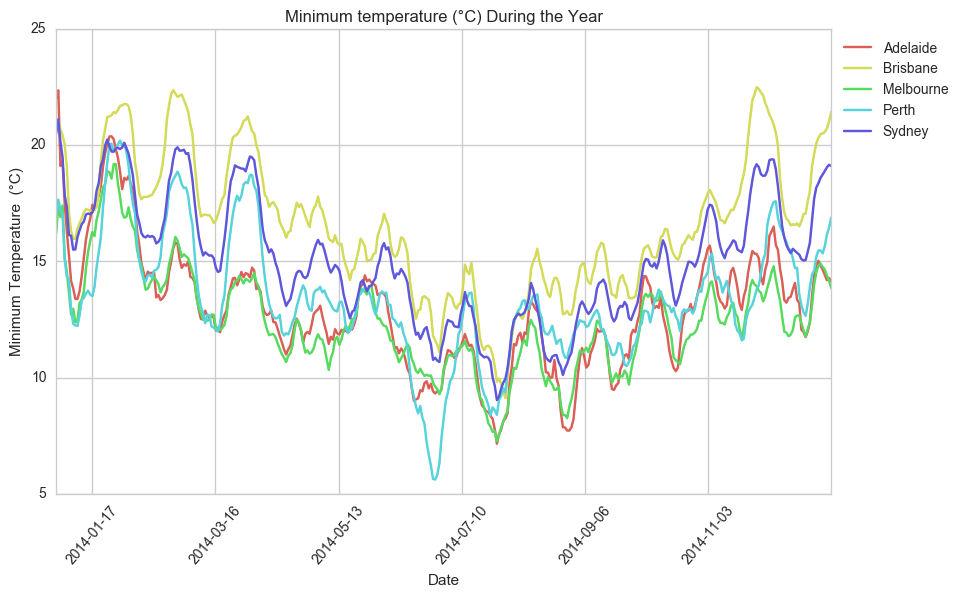

In [120]:
col = "MinTemp"
ncol = roll(df, col, 15)

#Residual
#df[ncol] = df[col] - df[ncol]

sns_plt = plot_time(df, ncol, rev_name_map);
sns_plt.set_ylabel(u"Maximaum Temperature (°C)");
sns_plt.set_ylabel(u"Minimum Temperature  (°C)");
plt.title(u"Minimum temperature (°C) During the Year");
#sns_plt.figure.savefig("./Plots/" + "RainfallWInter.png")

## Clouds

Oktas are often referenced in aviation weather forecasts and low level forecasts: SKC = Sky clear (0 oktas); FEW = Few (1 to 2 oktas); SCT = Scattered (3 to 4 oktas); BKN = Broken (5 to 7 oktas); OVC = Overcast (8 oktas); NSC = nil significant cloud; CAVOK = ceiling and visibility okay.[3]

In [121]:
cols = ["9am_Clouds", "3pm_Clouds"]

oktas_val = {0:0,
             1:1, 2:1,
             3:2, 4:2,
             5:3, 6:3,7:3,
             8:4}

oktas_map = {0:"SkyClear",
             1:"Few",2:"Few",
             3:"Scattered",4:"Scattered",
             5:"Broken",6:"Broken",7:"Broken",
             8:"Overcast"}

for c in cols:
    df[c + "_Av"] =  df[c].map(lambda x: oktas_val[x])

print "Pearson corr:", pearsonr(df["9am_Clouds"], df["3pm_Clouds"])
print "Pearson corr for Av. units", pearsonr(df["9am_Clouds_Av"], df["3pm_Clouds_Av"])

Pearson corr: (0.7356319935964515, 1.03199845315974e-310)
Pearson corr for Av. units (0.7507149471797891, 0.0)


In [122]:
cols = ["9am_Clouds", "3pm_Clouds", "9am_Clouds_Av", "3pm_Clouds_Av"]
order = calc_stat(df, cols)

#AddNoise
# topl[col + "_Noise"] = topl[col] + np.random.normal(scale=0.5,size=len(topl))
# pal = sns.palettes.hls_palette()[1:]
# sns.swarmplot(x="City", y=col + "_Noise", data=topl, palette=pal, ax=ax);
print order

               Adelaide  Brisbane  Melbourne  Perth  Sydney
Type                                                       
9am_Clouds          0.0       2.0        4.0    1.0     3.0
3pm_Clouds          0.0       2.0        3.0    1.0     4.0
9am_Clouds_Av       0.0       2.0        4.0    1.0     3.0
3pm_Clouds_Av       0.0       3.0        1.0    2.0     4.0


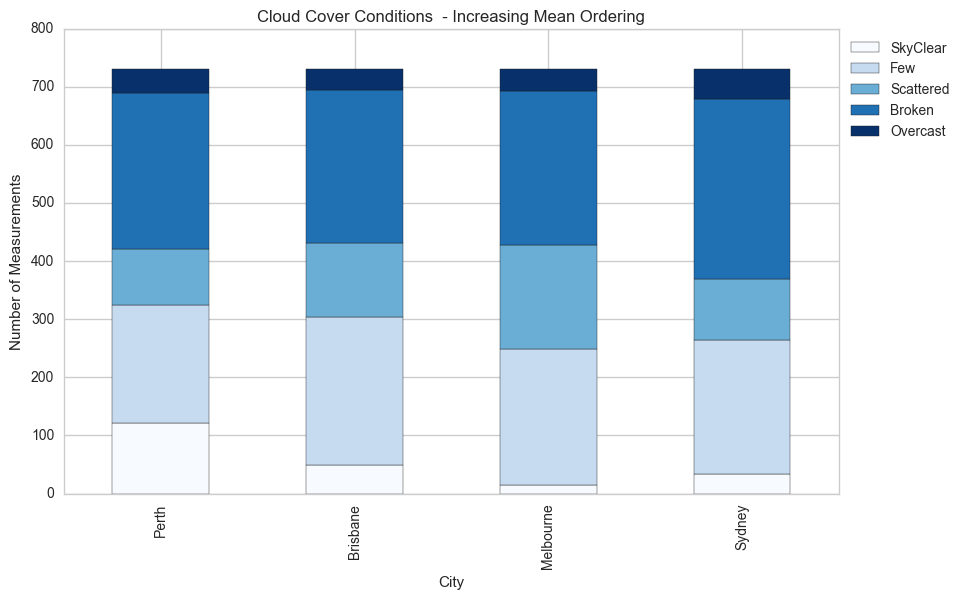

In [123]:
#Merge 9am and 3pm

col = "9am_Clouds_Av"
df[col] = df[col[:-3]].map(lambda x: oktas_map[x])
df1 = df[df.City != "Adelaide"].groupby(['City', col])['City'].count().unstack(col).fillna(0)
df1 = df1[["SkyClear","Few", "Scattered", "Broken", "Overcast"]]

col = "3pm_Clouds_Av"
df[col] = df[col[:-3]].map(lambda x: oktas_map[x])
df2 = df[df.City != "Adelaide"].groupby(['City', col])['City'].count().unstack(col).fillna(0)
df2 = df2[["SkyClear","Few", "Scattered", "Broken", "Overcast"]]

topl = df1.add(df2, fill_value=0)

col = "3pm_Clouds"
topl["Sort"] = topl.reset_index()["City"].map(lambda x: order.loc[col,][x]).values
topl = topl.sort_values("Sort", ascending=True)

f, ax = plt.subplots(1,1,figsize=(PW,PH))

colors = plt.cm.Blues(np.linspace(0, 1, 5))
ax = topl[topl.columns[:-1]].plot(kind='bar', stacked=True, color=colors, ax=ax);
plt.legend(bbox_to_anchor=(1, 1), loc=2);

ax.set_ylabel("Number of Measurements")
plt.title("Cloud Cover Conditions  - Increasing Mean Ordering");

SpearmanrResult(correlation=-0.4393665010414527, pvalue=5.270389320539989e-87)


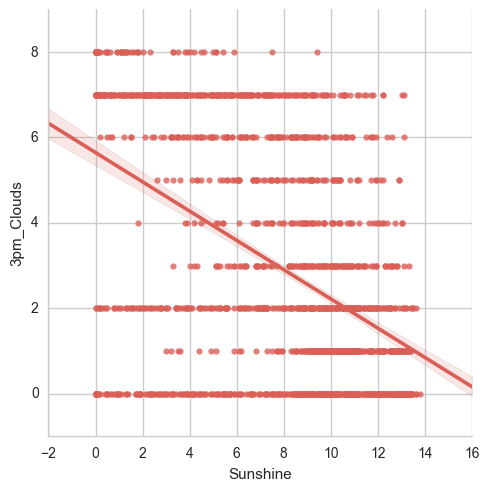

In [124]:
#Coorrelation with number of sunny hours
print spearmanr(df["Sunshine"], df["3pm_Clouds"])
sns.lmplot(x="Sunshine", y="3pm_Clouds", data=df);

## Rainfall

In [125]:
#Scoring
cols = ["Rainfall"]
order = calc_stat(df, cols)
order

,Adelaide,Brisbane,Melbourne,Perth,Sydney
Type,,,,,
Rainfall,1.0,3.0,0.0,2.0,4.0


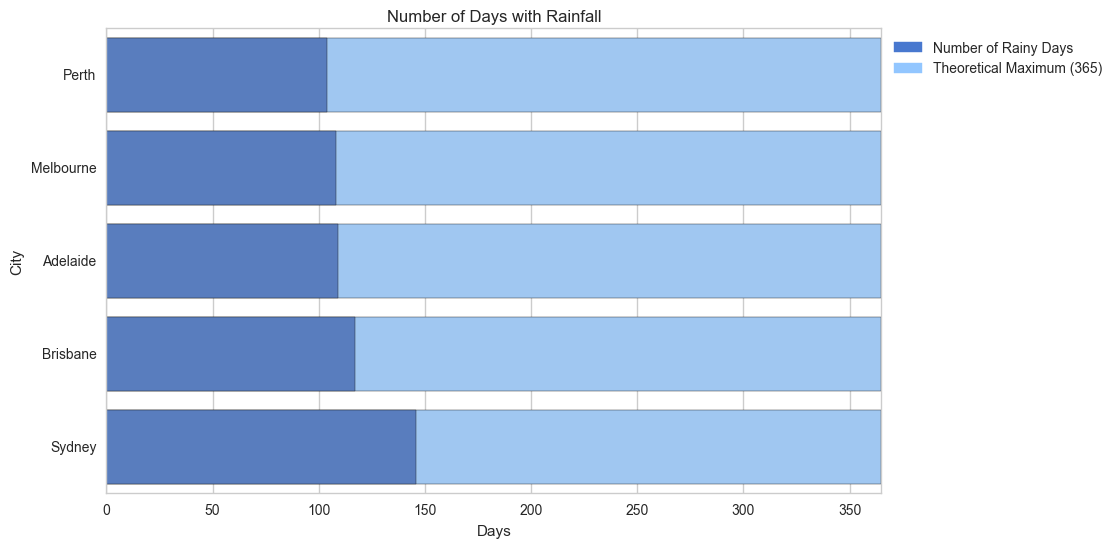

In [126]:
##Percantage of days without rain
df["HasRain"] = df["Rainfall"].apply(lambda x: 1.0 if x > 0 else 0.0) 
topl = df.groupby("City",as_index=False).sum()[["HasRain","City"]] 
#topl["HasRain"] /= days
topl["Total"]  = 1.0 * days
topl = topl.sort_values("HasRain")

f, ax = plt.subplots(1,1,figsize=(PW,PH))

sns.set_color_codes("pastel")
sns_plt = sns.barplot(x="Total", y="City", data=topl, label="Total", color="b")
sns.set_color_codes("muted")
sns_plt = sns.barplot(x="HasRain", y="City", data=topl, label="Total", color="b");

sns_plt.set_xlabel("Days")
sns_plt.set_xlim(0,days)

red_patch = mpatches.Patch(color='b', label='Number of Rainy Days')
sns.set_color_codes("pastel")
yellow_patch = mpatches.Patch(color='b', label='Theoretical Maximum (365)') 

plt.legend(handles=[red_patch, yellow_patch], bbox_to_anchor=(1, 1), loc=2);

plt.title('Number of Days with Rainfall');

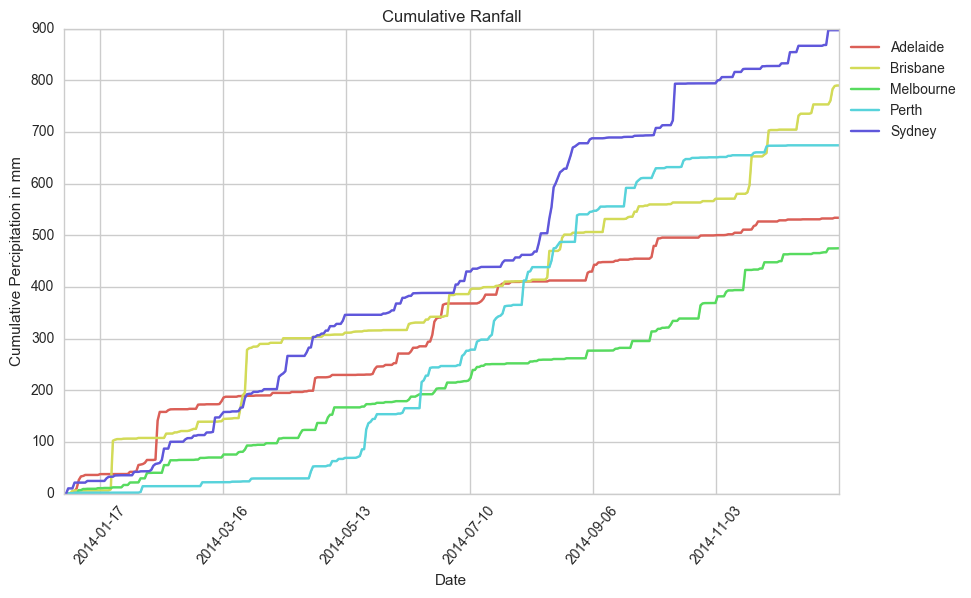

In [95]:
col = "Rainfall"
ncol = cumsumCat(df, col)

topl = df.rename(index=str, columns=rev_name_map)
sns_plt = plot_time(df, ncol, rev_name_map)

sns_plt.set_ylabel("Cumulative Percipitation in mm");
plt.title("Cumulative Ranfall");

#sns_plt.figure.savefig("./Plots/" + "CumulativeRainFall.png")

## Evaporation/Humidity

In [206]:
#Avearging 9am and 3pm
df["Average Rel. Humidity"] = (df["9am_RelHumid"] + df["3pm_RelHumid"]) / 2
#Scoring
cols = ["Evaporation", "9am_RelHumid", "3pm_RelHumid","Average Rel. Humidity"]
order = calc_stat(df, cols)

order

,Adelaide,Brisbane,Melbourne,Perth,Sydney
Type,,,,,
Evaporation,2.0,4.0,0.0,3.0,1.0
9am_RelHumid,0.0,1.0,4.0,2.0,3.0
3pm_RelHumid,0.0,3.0,2.0,1.0,4.0
Average Rel. Humidity,0.0,2.0,3.0,1.0,4.0


In [214]:
cities = sorted(df.groupby("City").sum().index)
idx = [int(order.loc["Average Rel. Humidity",][x]) for x in cities]
print idx, np.argsort(idx)

[0, 2, 3, 1, 4] [0 3 1 2 4]


In [215]:
def plot_dists(df, p, order=None, plt_type="violin"):  
    
    for col in p:
        if df[col].dtype == object or df[col].dtype == "datetime64[ns]":
            continue
        else:
            topl = df
            if len(topl) > 0:
                f, ax = plt.subplots(1, 1, figsize=(PW,PH))
                
                if order is not None:
                    topl = stat_order(df, order, col)
                
                old_col = col
                col, topl = rename_for_plt(topl, col)
               
                
                plt.title(col + " - Increasing Mean Ordered")
                pal = sns.diverging_palette(200, 20, s=75, l=75, n=2)
                if plt_type == "violin":     
                    sns_plt = sns.violinplot(split=True,x="City", y=col, hue="Season", data=topl, palette=pal, ax=ax)
                elif plt_type == "violin_ns":
                    cities = sorted(topl.groupby("City").sum().index)
                    idx = np.argsort([int(order.loc[old_col,][x]) for x in cities])
                    pal = np.array(col_pal)[idx]
                    sns.set_palette(pal)
            
                    sns_plt = sns.swarmplot(x="City", y=col, hue="City", data=topl, ax=ax)
                    sns.set_palette(col_pal)
                elif plt_type == "boxplot":
                    sns_plt = sns.boxplot(x="City", y=col, hue="Season", data=topl, palette=pal, ax=ax)

                plt.legend(bbox_to_anchor=(1, 1), loc=2)

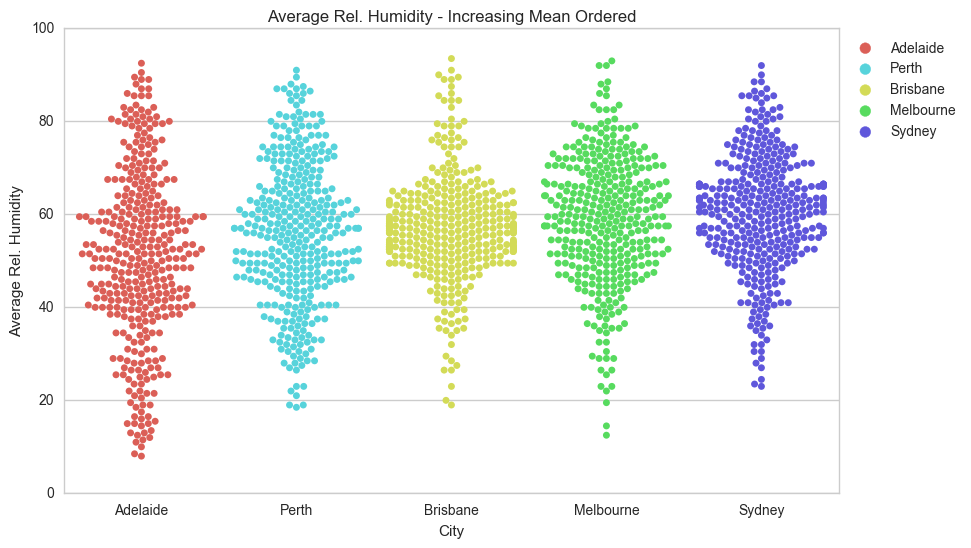

In [216]:
cols = ["Average Rel. Humidity"]
plot_dists(df, cols, order, "violin_ns")

Pearson corr: SpearmanrResult(correlation=-0.43960361841841555, pvalue=4.162505247389324e-87)


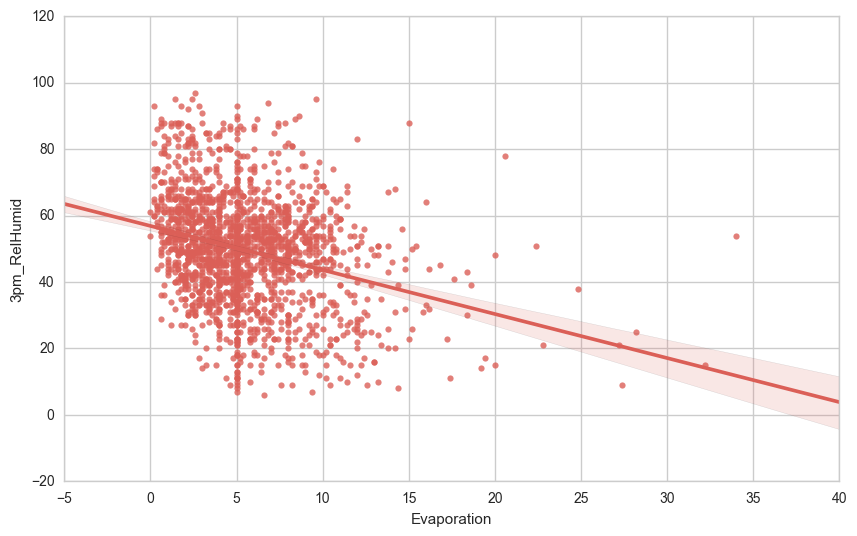

In [149]:
#Correlation with number of sunny hours
f, ax = plt.subplots(figsize=(PW, PH))
print "Pearson corr:", spearmanr(df["Evaporation"], df["Average Rel. Humidity"])
sns_plt = sns.regplot(x="Evaporation", y="3pm_RelHumid", data=df);

## Wind

## ARIMA Modeling

In [19]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller

In [20]:
def test_stat(series):
    dftest = adfuller(series)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

Test Statistic                -9.505205e+00
p-value                        3.361719e-16
Lags Used                      4.000000e+00
Number of Observations Used    3.600000e+02
Critical Value (5%)           -2.869602e+00
Critical Value (1%)           -3.448646e+00
Critical Value (10%)          -2.571065e+00
dtype: float64


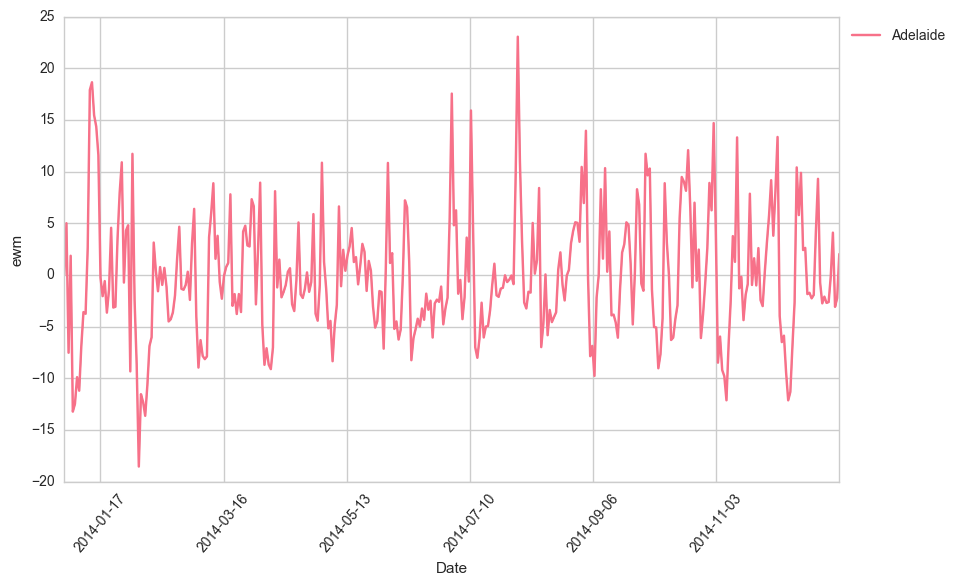

In [23]:
col= u'MaxTemp'
city =  "Adelaide"

totst = df[df.City == city].copy()

ncol = "ewm"
totst[ncol] = pd.DataFrame.ewm(totst[col].to_frame(), halflife=10).mean()

totst[ncol] = totst[col] - totst[ncol]

sns_plt = plot_time(totst, ncol, rev_name_map);
sns_plt.figure.savefig("./Plots/" + "MinTemp.png")

test_stat(totst[ncol])

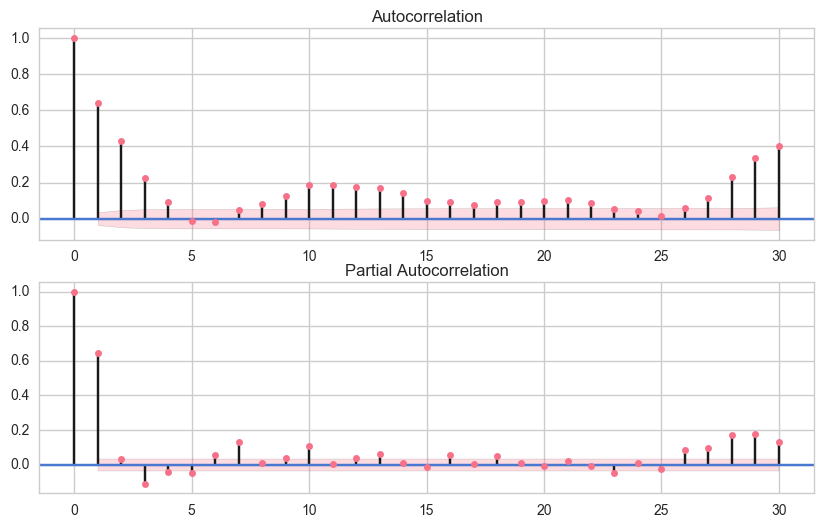

In [24]:
#Test
series = totst[col]

lags = 30
f, ax = plt.subplots(2,1,figsize=(PW,PH)) 
smt.graphics.plot_acf(series, lags=lags, ax=ax[0], alpha=0.5);
smt.graphics.plot_pacf(series, lags=lags, ax=ax[1], alpha=0.5);

In [25]:
# col = u'Maximum temperature (°C)'
# window = 5
# ncol = roll(df, col, window)

# #Residual
# #df[ncol] = df[col] - df[ncol]

# topl = df#[df.Season == "Winter"]
# plot_time(topl, ncol)
# sns_plt.figure.savefig("./Plots/" + "MaxTemp.png")

In [27]:
mdl = smt.AR(series).fit(maxlag=30, ic='aic', trend='nc')
#alpha
mdl.params[0]

/Users/markopetkovic/anaconda/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


0.49141621389165513

In [28]:
mdl = ARMA(series,order=(0,1,2)).fit(maxlag=30, ic='aic', trend='nc')
mdl.params[0]

/Users/markopetkovic/anaconda/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


0.8130437882365957